In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import ROOT as r
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
import multiprocessing

import time
from datetime import timedelta
from my_roc_auc3 import my_roc_auc
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The xgboost version is {}.'.format(xgb.__version__))

#Get total no of avaliable threads
nthreads = multiprocessing.cpu_count()

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++   -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.24/02
The scikit-learn version is 0.24.2.
The xgboost version is 1.4.0.


In [2]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2016preVFP', '2016postVFP', '2018','2017']
var_dict = [{}, {}, {}]
for year in years:
  print(f'Processing {year}')
  result = load(f"../results/{year}/makeDF/output_WJet2.coffea")
  if isinstance(result,tuple):
      result = result[0]
  for varName in result:
    for i in range(2,3):
      if f'{i}jets' in varName:
        if varName.replace(f'_{i}jets','') in var_dict[i]:
          var_dict[i][varName.replace(f'_{i}jets','')] = np.append(var_dict[i][varName.replace(f'_{i}jets','')],result[varName].value)
        else:
          var_dict[i][varName.replace(f'_{i}jets','')] = result[varName].value
df = pd.DataFrame(var_dict[i])



Processing 2016preVFP
Processing 2016postVFP
Processing 2018
Processing 2017


In [3]:
data_clean = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
data_cuts = data_clean[(data_clean['weight']!=0)&(data_clean['opp_charge']==1)&(data_clean['e_m_Mass']>115)&(data_clean['e_m_Mass']<135)&((data_clean['label']==1)|(data_clean['label']==0))]
data_vbf = data_cuts[data_cuts.isVBFcat==1]
data_vbf.loc[:, ('absweight')] = data_vbf['weight'].abs()
#data_vbf['absweight'].loc[data_vbf['label']==1] /= data_vbf[data_vbf['label']==1]['e_m_Mass_reso']

# split data into X and y
X = data_vbf
Y = data_vbf['label']

# split data into train and tsest sets
seed = 123
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
#X_train_pos, X_test_pos, y_train_pos, y_test_pos = X_train[X_train['weight']>0], X_test[X_test['weight']>0], y_train[X_train['weight']>0], y_test[X_test['weight']>0]
X_train_pos, X_test_pos, y_train_pos, y_test_pos = X_train, X_test, y_train, y_test

#Rescale signal weight to bkg weight
total_bkg_train_weights = X_train_pos.loc[X_train_pos['label'] == 0]['absweight'].sum()
total_sig_train_weights = X_train_pos.loc[X_train_pos['label'] == 1]['absweight'].sum()
sig_to_bkg_ratio = total_bkg_train_weights/total_sig_train_weights
print('Total Bkg Training weights', 'Total Sig Training weights')
print(total_bkg_train_weights, total_sig_train_weights)
print(sig_to_bkg_ratio)

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Total Bkg Training weights Total Sig Training weights
498.4146690328607 681.6751179146667
0.7311615987357384


In [4]:
data_125 = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)&(data_clean['is2016preVFP']==1)]
data_120 = data_clean[(data_clean['label']==120)&(data_clean['opp_charge']==1)&(data_clean['is2016preVFP']==1)]
data_130 = data_clean[(data_clean['label']==130)&(data_clean['opp_charge']==1)&(data_clean['is2016preVFP']==1)]

In [5]:
feature_names = ['Zeppenfeld_DeltaEta', 'met', 'DeltaEta_e_m', 'empt', 'j1pt', 'DeltaEta_j1_j2', 'j1_j2_mass', 'Ht_had', 'Rpt', 'j2pt', 'pt_cen_Deltapt']
#feature_names = ['Zeppenfeld_DeltaEta', 'Ht_had', 'Rpt', 'DeltaEta_j1_j2', 'j1_j2_mass', 'j2pt', 'pt_cen_Deltapt', 'j1pt', 'empt', 'met', 'DeltaEta_e_m'] 

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Time spent on training 0:00:16.794603
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=64, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=10, scale_pos_weight=0.7311615987357384,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


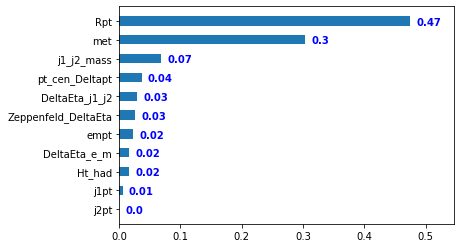

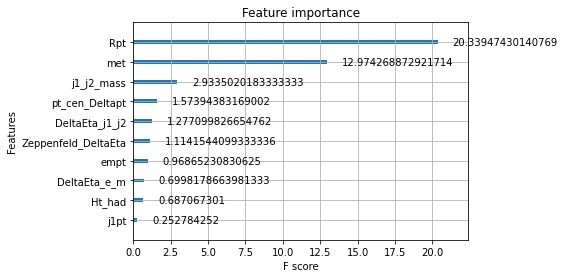

AUC of training set: 0.929266
AUC of testing set: 0.929712
Difference: -0.02


In [6]:
# Train with the default model to select features
tic = time.time()
model = xgb.XGBClassifier(n_jobs=nthreads, objective='binary:logistic', scale_pos_weight=sig_to_bkg_ratio, max_depth=3, reg_lambda=10, reg_alpha=10)#, reg_lambda=10, reg_alpha=10, seed=123, learning_rate=0.1, n_estimators=50)
model.fit(X_train_pos[feature_names], y_train_pos, early_stopping_rounds=10, sample_weight=X_train_pos['absweight'], eval_set = [(X_train_pos[feature_names], y_train_pos), (X_test_pos[feature_names], y_test_pos)], eval_metric='auc', sample_weight_eval_set = [X_train_pos['absweight'], X_test_pos['absweight']], verbose=False)
toc = time.time()
print("Time spent on training %s"%str(timedelta(seconds=toc - tic)))
print(model)

#Check the feature ranking
importances = model.feature_importances_
sorted_importance = [y for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
sorted_features = [x for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, height=0.5)
plt.xlim(0, max(sorted_importance)*1.15)
for i, v in enumerate(sorted_importance):
    plt.text(v+0.01, i-0.2, str(round(v,2)), color = 'blue', fontweight = 'bold')
plt.show()

xgb.plot_importance(model, importance_type="gain")
plt.show()

#Check also the auc
results = model.evals_result()
print ("AUC of training set: %f"%results['validation_0']['auc'][-1])
print ("AUC of testing set: %f"%results['validation_1']['auc'][-1])
print('Difference: %.2f'%((results['validation_0']['auc'][-1]-results['validation_1']['auc'][-1])*100/(results['validation_0']['auc'][-1]+results['validation_1']['auc'][-1])))

#Modify features in the cell above accordingly and run again

In [7]:
X_train['mva'] = model.predict_proba(X_train[feature_names])[:,1]
X_test['mva'] = model.predict_proba(X_test[feature_names])[:,1]
X['mva'] = model.predict_proba(X[feature_names])[:,1]
print('Train', my_roc_auc(y_train.to_numpy(), X_train['mva'].to_numpy(), X_train['weight'].to_numpy()))
print('Test', my_roc_auc(y_test.to_numpy(), X_test['mva'].to_numpy(), X_test['weight'].to_numpy()))
print('Overall', my_roc_auc(Y.to_numpy(), X['mva'].to_numpy(), X['weight'].to_numpy()))

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_712696/2125479340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mva'] = model.predict_proba(X_train[feature_names])[:,1]
/tmp/ipykernel_712696/2125479340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['mva

Train 0.9335436647816859
Test 0.9289601392937089
Overall 0.9321246919051898


In [8]:
catcatcat2 = 'VBF cat'
catcatcat = 'vbf'

0.13282154201532523
0.06782979392919045


/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/plot.py:452: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom ** 2)
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/plot.py:435: RuntimeWarning: inval

TFile**		Overtraining.root	
 TFile*		Overtraining.root	
  KEY: TH1D	Bkg Testing Samples;1	A.U.
  KEY: TH1D	Signal Testing Samples;1	A.U.
  KEY: TH1D	Bkg Training Samples;1	A.U.
  KEY: TH1D	Signal Training Samples;1	A.U.
Chi2 = 46.652568, Prob = 0.132822, NDF = 37, igood = 0
Chi2 = 58.729413, Prob = 0.0678298, NDF = 44, igood = 0


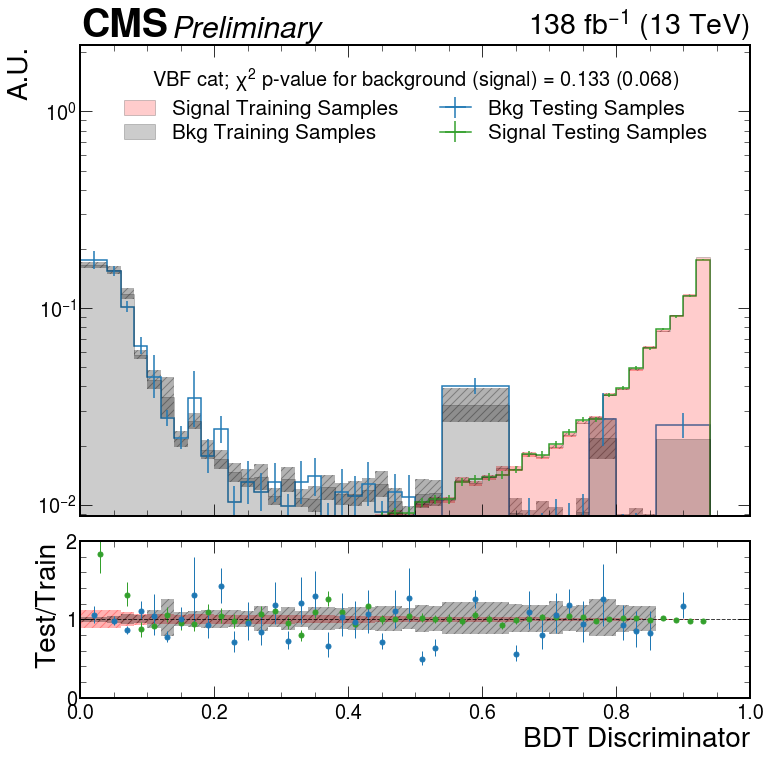

In [9]:
import mplhep
import math

%matplotlib inline

from coffea import hist
df_test = X.loc[X_test.index, ['mva','label','weight']]
df_train = X.loc[X_train.index, ['mva','label','weight']]
df_test_bkg = df_test[df_test['label']==0]
df_train_bkg = df_train[df_train['label']==0]
df_test_signal = df_test[df_test['label']==1]
df_train_signal = df_train[df_train['label']==1]

binning = 50
og_bin = hist.Bin('MVA', 'BDT Discriminator', binning, 0., 1).edges()

h = hist.Hist('A.U.', hist.Bin('MVA', 'BDT Discriminator', binning, 0., 1), hist.Cat("sample", "sample"))
h.fill(MVA=df_test_bkg['mva'].to_numpy(), sample='Bkg Testing Samples', weight=df_test_bkg['weight'].to_numpy())
h.fill(MVA=df_test_signal['mva'].to_numpy(), sample='Signal Testing Samples', weight=df_test_signal['weight'].to_numpy())
h.fill(MVA=df_train_bkg['mva'].to_numpy(), sample='Bkg Training Samples', weight=df_train_bkg['weight'].to_numpy())
h.fill(MVA=df_train_signal['mva'].to_numpy(), sample='Signal Training Samples', weight=df_train_signal['weight'].to_numpy())

import uproot3
root_file = uproot3.recreate("Overtraining.root")

for sample in ['Bkg Testing Samples', 'Signal Testing Samples', 'Bkg Training Samples', 'Signal Training Samples']:
    root_file[sample] = hist.export1d(h.integrate('sample', sample))

f_in = r.TFile('Overtraining.root')
f_in.ls()
h_test_bkg_root = f_in.Get('Bkg Testing Samples')
h_train_bkg_root = f_in.Get('Bkg Training Samples')
h_test_sig_root = f_in.Get('Signal Testing Samples')
h_train_sig_root = f_in.Get('Signal Training Samples')

list_of_hist = [h_test_bkg_root, h_train_bkg_root, h_test_sig_root, h_train_sig_root]

import array
Binning = [array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])]

for j in range(len(list_of_hist)):
    prev_bin = 0
    for i in range(1,len(og_bin)):
        effCon = ((list_of_hist[j].GetBinContent(i)**2)/(list_of_hist[j].GetBinError(i)**2)) if list_of_hist[j].GetBinError(i) != 0 else 0
        if (effCon+prev_bin) > 10:
            prev_bin=0
            Binning[j].append(og_bin[i])
        else:
            prev_bin+=effCon
    if Binning[j][-1]!=1: Binning[j].append(1)

if len(Binning[0]) < len(Binning[1]):
    Binning[1] = array.array('d', [p for p in Binning[0]])
else:
    Binning[0] = array.array('d', [p for p in Binning[1]])
if len(Binning[2]) < len(Binning[3]):
    Binning[3] = array.array('d', [p for p in Binning[2]])
else:
    Binning[2] = array.array('d', [p for p in Binning[3]])

for j in range(len(list_of_hist)):
    list_of_hist[j] = list_of_hist[j].Rebin(len(Binning[j])-1, "", Binning[j])

for c in range(5):
    for j in range(len(list_of_hist)):
        poping_list = []
        for i in range(1,list_of_hist[j].GetNbinsX()+1):
            effCon = ((list_of_hist[j].GetBinContent(i)**2)/(list_of_hist[j].GetBinError(i)**2)) if list_of_hist[j].GetBinError(i) != 0 else 0
            if effCon == 0: continue
            if effCon < 10:
                poping_list.append(i-1)
        Binning[j] = array.array('d', [Binning[j][e] for e in range(len(Binning[j])) if not e in poping_list]) 
        if Binning[j][-1]!=1: Binning[j].append(1)

    if len(Binning[0]) < len(Binning[1]):
        Binning[1] = array.array('d', [p for p in Binning[0]])
    else:
        Binning[0] = array.array('d', [p for p in Binning[1]])
    if len(Binning[2]) < len(Binning[3]):
        Binning[3] = array.array('d', [p for p in Binning[2]])
    else:
        Binning[2] = array.array('d', [p for p in Binning[3]])

    for j in range(len(list_of_hist)):
        list_of_hist[j] = list_of_hist[j].Rebin(len(Binning[j])-1, "", Binning[j])
    for j in range(len(list_of_hist)):
        for i in range(1,list_of_hist[j].GetNbinsX()+1):
            effCon = ((list_of_hist[j].GetBinContent(i)**2)/(list_of_hist[j].GetBinError(i)**2)) if list_of_hist[j].GetBinError(i) != 0 else 0

#print(Binning1, Binning2)

p_bkg = list_of_hist[0].Chi2Test(list_of_hist[1], 'WWP')
p_sig = list_of_hist[2].Chi2Test(list_of_hist[3], 'WWP')

print(p_bkg)
print(p_sig)

scales = {
    'Bkg Testing Samples': 1/np.sum(df_test_bkg['weight'].to_numpy()),
    'Signal Testing Samples': 1/np.sum(df_test_signal['weight'].to_numpy()),
    'Bkg Training Samples': 1/np.sum(df_train_bkg['weight'].to_numpy()),
    'Signal Training Samples': 1/np.sum(df_train_signal['weight'].to_numpy()),
}

h.scale(scales, axis='sample')

plt.style.use(mplhep.style.CMS)

plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

#For ratio plots
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12,12),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.08)

# fig = plt.figure(
#         figsize=(12,12),
#       )
# ax = plt.axes()

from cycler import cycler
colors = ['#1f78b4','#33a02c']
ax.set_prop_cycle(cycler(color=colors))

#np.array(Binning1)
hist.plot1d(h[:, ['Bkg Testing Samples']].rebin("MVA", hist.Bin("MVA", "rebinned MVA", np.array(Binning[0]))), ax=ax, clear=False) 
hist.plot1d(h[:, ['Signal Testing Samples']].rebin("MVA", hist.Bin("MVA", "rebinned MVA", np.array(Binning[2]))), ax=ax, clear=False) #density=True, 
#print(fig[-1].get_color())

#For ratio plots
facecolor = {'Signal': ['#33a02c', 'r'], 'Bkg': ['#1f78b4', 'k']}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'elinewidth': 1,
}
denom_fill_opts = {
    'alpha': 0.3, 
    'hatch': '///'
}

error_opts = {
    'label': '',
    'hatch': '///',
    'alpha': 0.3,
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}

fill_opts = {
    'edgecolor': (0,0,0,0.3), 
    'alpha': 0.2, 
}


for fc, bin12 in zip(facecolor, [Binning[2], Binning[0]]):
    error_opts['facecolor'] = facecolor[fc][1]
    fill_opts['facecolor'] = facecolor[fc][1]
    hist.plot1d(
        h[:, f'{fc} Training Samples'].rebin("MVA", hist.Bin("MVA", "rebinned MVA", np.array(bin12))),
        ax=ax,
        overlay='sample',
        stack=True,
        clear=False,
        fill_opts=fill_opts,
        error_opts=error_opts,
    )
    data_err_opts['color'] = facecolor[fc][0]
    denom_fill_opts['color'] = facecolor[fc][1]
    hist.plotratio(
        num=h.integrate('sample', f'{fc} Testing Samples').rebin("MVA", hist.Bin("BDT Discriminator", "BDT Discriminator", np.array(bin12))),
        denom=h.integrate('sample', f'{fc} Training Samples').rebin("MVA", hist.Bin("BDT Discriminator", "BDT Discriminator", np.array(bin12))),
        ax=rax,
        error_opts=data_err_opts,
        denom_fill_opts=denom_fill_opts,
        guide_opts={},
        unc='num',
        clear=False
    )


ax.set_yscale('log')
ax.set_ylim(10**(math.log10(min([i for i in sorted(h[:, 'Bkg Training Samples'].values()[('Bkg Training Samples',)]) if i!=0]))+0.5), 10**(math.log10(h[:, 'Bkg Training Samples'].values()[('Bkg Training Samples',)].max()+2)))
#ax.set_ylim(0.000001, 10**(math.ceil(math.log10(h[:, 'Bkg Training Samples'].sum("MVA").values()[('Bkg Training Samples',)]))+1))
#ax.set_ylim(0, 10**5)
ax.set_xlabel(None)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, ncol=2, loc=9, title=f'{catcatcat2}; $\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})')

rax.set_xlim(0, 1)
rax.set_ylim(0, 2)
rax.set_ylabel("Test/Train", loc='center')

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
fig.savefig(f'plots/BDTValid/{catcatcat}_overtrain.png')

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_513500/1172127952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bkg['mva'] = model.predict_proba(data_bkg[feature_names])[:,1]


[0.         0.05214586 0.10601064 0.39050201 1.001     ]
1444.794610673465
390.7818058900059
331.4946057939935
361.12683840228
361.3913605871856


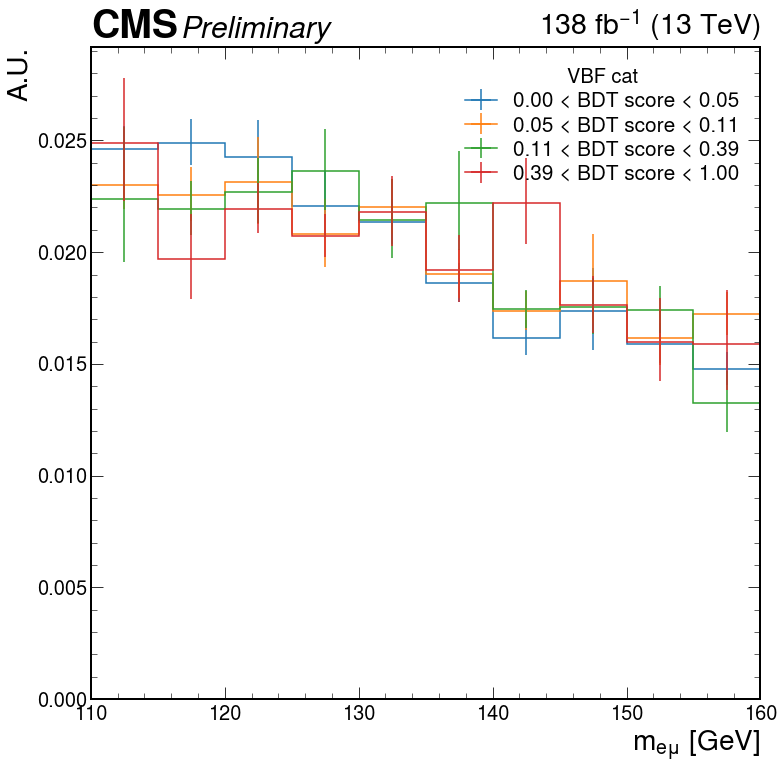

In [65]:
from coffea import hist

#Get the background
data_bkg = data_clean[(data_clean['label']==0)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]
data_bkg['mva'] = model.predict_proba(data_bkg[feature_names])[:,1]

#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW
wq = DescrStatsW(data=data_bkg['mva'], weights=data_bkg['weight'])
#quantiles = wq.quantile(probs=np.array([0, 0.20, 0.40, 0.60, 0.80, 1]), return_pandas=False)
quantiles = wq.quantile(probs=np.array([0, 0.25, 0.50, 0.75, 1]), return_pandas=False)
#quantiles = wq.quantile(probs=np.array([0, 0.25, 1]), return_pandas=False)
#Fill in sliced invariant mass according to MVA quantiles
h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 10, 110, 160), hist.Cat("sample", "sample"))
#scales = {}
quantiles[0] = 0
quantiles[-1] = 1.001
quantiles[1]+=0.001
print(quantiles)
print(data_bkg['weight'].sum())
for i in range(len(quantiles)-1):
    quant25 = data_bkg[(data_bkg['mva']<quantiles[i+1])&(data_bkg['mva']>=quantiles[i])]
    print(quant25['weight'].sum())
    label = f'{quantiles[i]:.2f} < BDT score < {quantiles[i+1]:.2f}'
    h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())
    #scales[label] = 1/np.sum(quant25['weight'].to_numpy())

#h_quan.scale(scales, axis='sample')

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

fig = plt.figure(
        figsize=(12,12),
      )

ax = hist.plot1d(h_quan, density=True)
#ax.set_ylim(0, 0.05)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, title=catcatcat2)

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
fig.savefig(f'plots/BDTValid/{catcatcat}_bkg.png')
# plt.text(0.5, 15, f'$\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})', 
#          fontsize=20,
#          horizontalalignment='center',
#          verticalalignment='top')





In [4]:
data_125 = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]
data_120 = data_clean[(data_clean['label']==120)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]
data_130 = data_clean[(data_clean['label']==130)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]

data_125['mva'] = model.predict_proba(data_125[feature_names])[:,1]
data_120['mva'] = model.predict_proba(data_120[feature_names])[:,1]
data_130['mva'] = model.predict_proba(data_130[feature_names])[:,1]

binning = 25
h_mass = hist.Hist('A.U.', hist.Bin('MVA', 'BDT Discriminator', binning, 0, 1), hist.Cat("sample", "sample"))

h_mass.fill(MVA=data_125['mva'].to_numpy(), sample='$m_{H}=125$GeV', weight=data_125['weight'].to_numpy())
h_mass.fill(MVA=data_130['mva'].to_numpy(), sample='$m_{H}=130$GeV', weight=data_130['weight'].to_numpy())
h_mass.fill(MVA=data_120['mva'].to_numpy(), sample='$m_{H}=120$GeV', weight=data_120['weight'].to_numpy())

scales = {
            '$m_{H}=125$GeV': binning/np.sum(data_125['weight'].to_numpy()),
            '$m_{H}=120$GeV': binning/np.sum(data_120['weight'].to_numpy()),
            '$m_{H}=130$GeV': binning/np.sum(data_130['weight'].to_numpy()),
        }

h_mass.scale(scales, axis='sample')

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

#For ratio plots
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12,12),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)

fig.subplots_adjust(hspace=.08)

error_opts = {
    'label': '',
    'hatch': '///',
    'facecolor': 'k',
    'alpha': 0.3,
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}

hist.plot1d(
    h_mass[:,'$m_{H}=125$GeV'],
    ax=ax,
    overlay='sample',
    stack=True,
    clear=False,
    fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.2, 'facecolor': 'k'},
    error_opts=error_opts,
)

from cycler import cycler
colors = ['#1f78b4','#33a02c']
ax.set_prop_cycle(cycler(color=colors))

hist.plot1d(h_mass[:,['$m_{H}=120$GeV', '$m_{H}=130$GeV']], ax=ax, clear=False)
ax.set_xlabel(None)

leg = ax.legend(fontsize='x-small', labelspacing=0.25, ncol=2, loc=9, title=catcatcat2)

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#33a02c',
            'elinewidth': 1,
        }


data_err_opts2 = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#1f78b4',
            'elinewidth': 1,
        }

hist.plotratio(
    num=h_mass[:,'$m_{H}=120$GeV'].sum('sample'),
    denom=h_mass[:,'$m_{H}=125$GeV'].sum('sample'),
    ax=rax,
    error_opts=data_err_opts2,
    denom_fill_opts={},
    guide_opts={},
    unc='num',
    clear=False
)

hist.plotratio(
    num=h_mass[:,'$m_{H}=130$GeV'].sum('sample'),
    denom=h_mass[:,'$m_{H}=125$GeV'].sum('sample'),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num',
    clear=False
)

rax.set_xlim(0, 1)
rax.set_ylim(0, 2)
rax.set_ylabel("Alt./Nomial", loc='center')

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
fig.savefig(f'plots/BDTValid/{catcatcat}_sig.png')
# plt.text(0.5, 15, f'$\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})', 
#          fontsize=20,
#          horizontalalignment='center',
#          verticalalignment='top')



NameError: name 'model' is not defined

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_488374/2738182902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sig['mva'] = model.predict_proba(data_sig[feature_names])[:,1]


[0.         0.6141187  0.75215966 0.83536786 1.001     ]
5642.46587992176
5642.482913091697
5642.186263811838
5642.772237371647


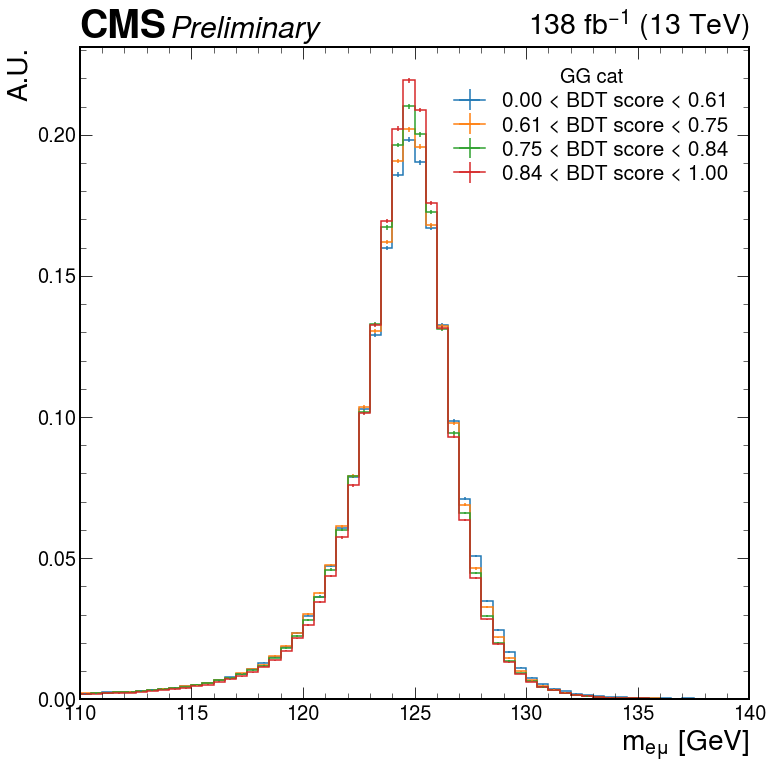

In [9]:
from coffea import hist

#Get the signal
data_sig = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)]#&(data_clean['isVBFcat']==0)]
data_sig['mva'] = model.predict_proba(data_sig[feature_names])[:,1]

#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW
wq = DescrStatsW(data=data_sig['mva'], weights=data_sig['weight'])
#quantiles = wq.quantile(probs=np.array([0, 0.1, 0.2, 0.3, 0.40, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), return_pandas=False)
#quantiles = wq.quantile(probs=np.array([0, 0.20, 0.40, 0.60, 0.80, 1]), return_pandas=False)
quantiles = wq.quantile(probs=np.array([0, 0.25, 0.50, 0.75, 1]), return_pandas=False)
quantiles[0] = 0
quantiles[-1] = 1.001
print(quantiles)

#Fill in sliced invariant mass according to MVA quantiles
h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 60, 110, 140), hist.Cat("sample", "sample"))
#scales = {}
#quantiles = [0,0.25,0.5,0.75,1]
for i in range(len(quantiles)-1):
    quant25 = data_sig[(data_sig['mva']<quantiles[i+1])&(data_sig['mva']>=quantiles[i])]
    print(quant25['weight'].sum())
    label = f'{quantiles[i]:.2f} < BDT score < {quantiles[i+1]:.2f}'
    h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())
    #scales[label] = 1/np.sum(quant25['weight'].to_numpy())

#h_quan.scale(scales, axis='sample')

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

fig = plt.figure(
        figsize=(12,12),
      )

ax = hist.plot1d(h_quan, density=True)
#ax.set_ylim(0, 0.05)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, title=catcatcat2)

lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
#fig.savefig(f'plots/BDTValid/{catcatcat}_sig.png')


In [67]:
#Save model if everything looks good
#model_out_file = "results/model_VBF.json"
#model.save_model(model_out_file)

In [29]:
from statsmodels.stats.weightstats import DescrStatsW
df_vbf = df[df.isVBFcat==1]
final_model = xgb.XGBClassifier()
final_model.load_model('results/model_VBF.json')
df_vbf['mva'] = final_model.predict_proba(df_vbf[feature_names])[:,1]
wq = DescrStatsW(data=df_vbf['mva'], weights=df_vbf['weight'])
quantiles = wq.quantile(probs=np.linspace(0,1,101), return_pandas=False)
quantiles[0], quantiles[-1] = 0, 1
for i in range(1,len(quantiles)):
    if quantiles[i] <= quantiles[i-1]:
        quantiles[i] = quantiles[i-1]+1e-17
np.set_printoptions(precision=20)
print(quantiles)
quantiles.dump(f"../results/SenScan/VBFcat_quantiles")

/tmp/ipykernel_980517/1302542146.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vbf['mva'] = final_model.predict_proba(df_vbf[feature_names])[:,1]


hi
hi
hi
hi
[0.                   0.03682514652609825  0.03682514652609826
 0.036825146526098265 0.03682514652609827  0.03682514652609828
 0.037471555173397064 0.03799299895763397  0.039274912327528
 0.04118327796459198  0.04248324781656265  0.04390975087881088
 0.047269873321056366 0.049865059554576874 0.05114586278796196
 0.05229900777339935  0.0547151155769825   0.05779317393898964
 0.06210092455148697  0.06448301672935486  0.06890399754047394
 0.07143661379814148  0.07494744658470154  0.07946103811264038
 0.08497413247823715  0.09232886135578156  0.09739534556865692
 0.1049189567565918   0.113283172249794    0.12377937138080597
 0.13593313097953796  0.14712749421596527  0.16083264350891113
 0.17455358803272247  0.1890791356563568   0.20653635263442993
 0.22275501489639282  0.24467065930366516  0.26542505621910095
 0.29145628213882446  0.3187672197818756   0.3428589999675751
 0.36717483401298523  0.3913414478302002   0.4120362102985382
 0.43470433354377747  0.4578189253807068   0.47

In [32]:
np.load(f"results/VBFcat_quantiles",allow_pickle=True)

array([0.                  , 0.03682514652609825 , 0.03682514652609826 ,
       0.036825146526098265, 0.03682514652609827 , 0.03682514652609828 ,
       0.037471555173397064, 0.03799299895763397 , 0.039274912327528   ,
       0.04118327796459198 , 0.04248324781656265 , 0.04390975087881088 ,
       0.047269873321056366, 0.049865059554576874, 0.05114586278796196 ,
       0.05229900777339935 , 0.0547151155769825  , 0.05779317393898964 ,
       0.06210092455148697 , 0.06448301672935486 , 0.06890399754047394 ,
       0.07143661379814148 , 0.07494744658470154 , 0.07946103811264038 ,
       0.08497413247823715 , 0.09232886135578156 , 0.09739534556865692 ,
       0.1049189567565918  , 0.113283172249794   , 0.12377937138080597 ,
       0.13593313097953796 , 0.14712749421596527 , 0.16083264350891113 ,
       0.17455358803272247 , 0.1890791356563568  , 0.20653635263442993 ,
       0.22275501489639282 , 0.24467065930366516 , 0.26542505621910095 ,
       0.29145628213882446 , 0.3187672197818756  , 